## Importing the Packages

In [1]:
!pip install arch
import yfinance as yf
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

#The volkswaggen buyout of porsche


Additionaly, we have defined another crucial date in the history of volkswagen (the disselgate scandal in sept 2015)

we will examine how this scandal affacted (price, returns , best fitting models and volatility trends)

The "Dieselgate" scandal, also known as "Emissionsgate," refers to a widespread controversy surrounding the illegal use of software in certain diesel vehicles manufactured by Volkswagen Group (VW) that allowed them to emit more harmful pollutants than legally allowed.

## Importing the Data

we are going directly scrape the data of the yahoo finance instead of importing a fixed dataset
the code will automatically impoert all the available data up to today

https://finance.yahoo.com/quote/VOW3.DE?p=VOW3.DE&.tsrc=fin-srch


https://finance.yahoo.com/quote/PAH3.DE?p=PAH3.DE&.tsrc=fin-srch

In [3]:
raw_data=yfinance.download(tickers="VOW3.DE,PAH3.DE,BMW.DE", interval="1d",
                           group_by="ticker", auto_adjust=True, threads=True)

[*********************100%%**********************]  3 of 3 completed


VOW3.DE,PAH3.DE,BMW.DE : these are the abbreviations for certain equities on the stock market

VOW3.DE,PAH3.DE: both companies are german based to make sure all the changes in value are stock specific, we need a market benchmark ideally
this would be some other automobile producers selling stocks on the german market so BMW seems like an obvious choice  

the DE indicates that this data was recorded from the german stock market

In [4]:
df=raw_data.copy()

## Defining Key Dates

we need to define several very importan dates in this business case

In [5]:
# Starting Date(this is the earliset date we have recorded values for both stocks )
start_date="2009-04-05"

# First Official Announcement - 49.9%(on that day VW announced they own 49.9% of porsche)
ann_1="2009-12-09"
# Second Official Announcement - 51.1%(Vw announced the purchase of the remaining 50.1%. that
# that means they have full ownership of porsche so we expect their values to move quite similarity
#after this point )
ann_2="2012-07-05"
#Ending Date (since the period from the second announcement until today is far longer than those in between so we need another date for us)
end_date="2014-01-01"
# Dieselgate (we a date for the diselgate scandal  )
d_gate="2015-09-20"

## Pre-processing the Data

In [6]:
# Extracting Closing Prices
df['vol']=df['VOW3.DE'].Close
df['por']=df['PAH3.DE'].Close
df['bmw']=df['BMW.DE'].Close
# Creating Returns
df['ret_vol']=df['vol'].pct_change(1).mul(100)
df['ret_por']=df['por'].pct_change(1).mul(100)
df['ret_bmw']=df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns(we will examine the volatility so we need to create square returns )
df['sq_vol']=df.ret_vol.mul(df.ret_vol)
df['sq_por']=df.ret_por.mul(df.ret_por)
df['sq_bmw']=df.ret_bmw.mul(df.ret_bmw)
# Extracting Volume(extract the number of purchases and sales each day )
df['q_vol']=df['VOW3.DE'].Volume
df['q_por']=df['PAH3.DE'].Volume
df['q_bmw']=df['BMW.DE'].Volume

the more a certain stock is being traded on a given day. the more likely it is for its price to fluctuate  

In [7]:
# Assigning the Frequency and Filling NA Values
df=df.asfreq('b')
df=df.fillna(method="bfill")

In [8]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

at this point we usually spilt the data into a training and a testing set but not this time because we are exaimining a spacific event in time rather than trying to predict the future

## Plotting the Prices

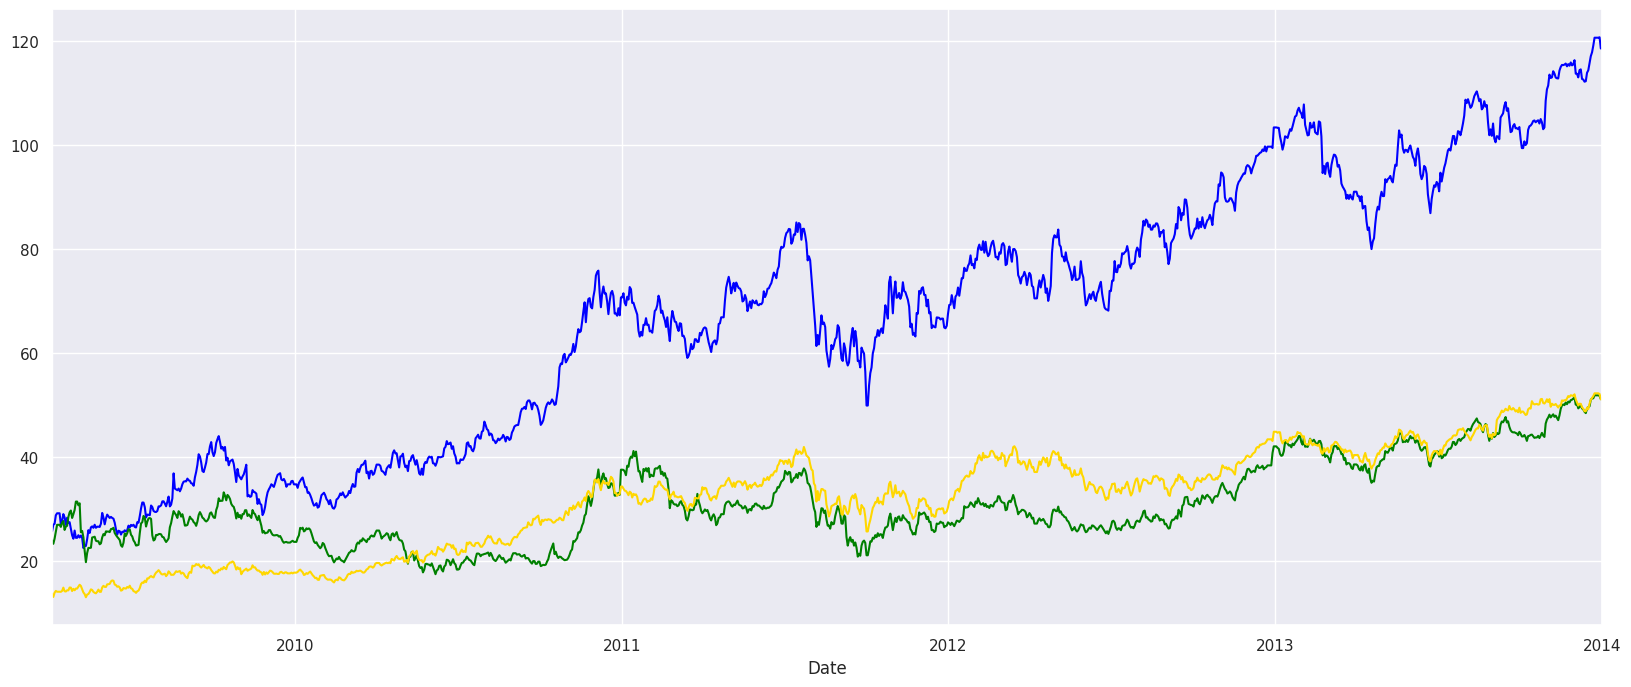

In [9]:
df['vol'][start_date:end_date].plot(figsize=(20,8),color='blue')
df['por'][start_date:end_date].plot(color='green')
df['bmw'][start_date:end_date].plot(color='gold')
plt.show()

there are trends of the entire automobile industry market

Vw prices (blue) shifts alot more in magnitude after the third quarter of 2009

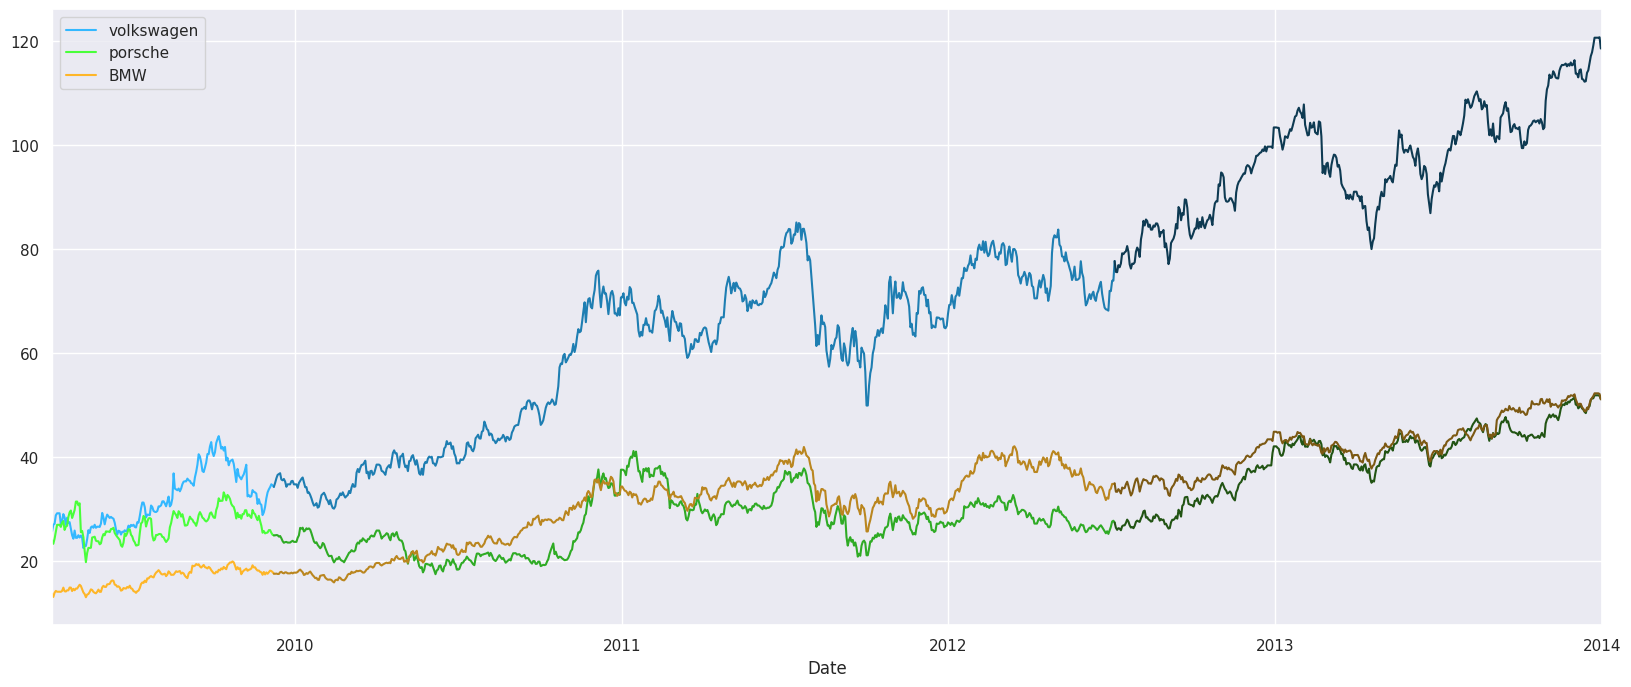

In [10]:
#color = "#33B8FF"
#color = "#49FF3A"
#color = "#FEB628"
df['vol'][start_date:ann_1].plot(figsize=(20,8),color='#33B8FF')
df['por'][start_date:ann_1].plot(color='#49FF3A')
df['bmw'][start_date:ann_1].plot(color='#FEB628')
#color = "#1E7EB2"
#color = "#2FAB25"
#color = "#BA861F"
df['vol'][ann_1:ann_2].plot(color='#1E7EB2')
df['por'][ann_1:ann_2].plot(color='#2FAB25')
df['bmw'][ann_1:ann_2].plot(color='#BA861F')
#color = "#0E3A52"
#color = "#225414"
#color = "#7C5913"
df['vol'][ann_2:end_date].plot(color='#0E3A52')
df['por'][ann_2:end_date].plot(color='#225414')
df['bmw'][ann_2:end_date].plot(color='#7C5913')
plt.legend(['volkswagen','porsche','BMW'])
plt.show()

prior to the first announcement we see that the 2 stocks, vw and porsche move in a similar fashion . however , volkswagen's numbers seem to be roughly twice as high

the gap between the 2 stocks grow bigger and bigger

if we look at BMW's numbers we will see that they resemble the porsche ones much closer than the vw ones or at least that's what it looks like

## Correlation

In [11]:
print("correlation among manufactures from  "+str(start_date)+ ' to ' +str(end_date)+'\n')
print('volkswagen and porsche correlation :\t'+str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('volkswagen and BMW correlation     :\t'+str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('porsche and BMW correlation        :\t'+str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

correlation among manufactures from  2009-04-05 to 2014-01-01

volkswagen and porsche correlation :	0.8359546992100739
volkswagen and BMW correlation     :	0.979937820540227
porsche and BMW correlation        :	0.805215781355038


higher correlation between VW and por this suggest vw moves in similar way to porsche

vw owns 100% of porsche by the end of this time interval

shouldn't the correlation be much higher ?

we need to examine 3 different intervals to better understand

Change in correlation from April 5,2009 to December 9, 2009 when the First announcement of Volkswagen holding 49% of Porche's shares was made

In [12]:
print("correlation among manufactures from  "+str(start_date)+ ' to ' +str(ann_1)+'\n')
print('volkswagen and porsche correlation :\t'+str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('volkswagen and BMW correlation     :\t'+str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('porsche and BMW correlation        :\t'+str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

correlation among manufactures from  2009-04-05 to 2009-12-09

volkswagen and porsche correlation :	0.6633583289382647
volkswagen and BMW correlation     :	0.8427607284664226
porsche and BMW correlation        :	0.6095038645844889


we see lower correlation all around with the porsche and BWM value taking the biggest hit

this suggest the stock prices of these brands weren't too similar before the start of the buyout

a possible explaination of this : porsche's evaluation becomes heavily tied to that of the VW then VW becomes market trend setter to BMW so all the companies have to adjust to it that

that way vw affects both por and bmw simultaneously.

one directly between vw and por and one indirectly between vw and bmw

then the pull of vw in times of boom makes it so that por and bmw appear to change in similiar mannar without a direct causal link between them

if this is indeed the case , then we expect that por and bmw correlation keeps increasing as vw grows as a market leader

we expect the vw por interdependence to also increase as vw continues to buy por shares

let's examine it

Change in correlation from December 9,2009 to July 5, 2012
when the Second announcement of Volkswagen holding 50.01% of Porche's shares(Full ownership) was made

Full Ownership:
In this context, "full ownership" refers to the situation where one company, in this case, Volkswagen, acquires a majority stake in another company, Porsche. When a company holds more than 50% of another company's shares, it gains controlling ownership or a controlling interest. This means that the majority owner (Volkswagen) has the power to influence and make significant decisions regarding the operations, management, and strategic direction of the acquired company (Porsche).

## (Second Announcement - Partial Ownership)

In [13]:
print("correlation among manufactures from  "+str(ann_1)+ ' to ' +str(ann_2)+'\n')
print('volkswagen and porsche correlation :\t'+str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('volkswagen and BMW correlation     :\t'+str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('porsche and BMW correlation        :\t'+str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

correlation among manufactures from  2009-12-09 to 2012-07-05

volkswagen and porsche correlation :	0.7428267730506107
volkswagen and BMW correlation     :	0.9795942999817504
porsche and BMW correlation        :	0.704272323684823


the intersting output here is the almost 98% corr between vw and bmw
if we look at the graph earlier , we can see that over that time period vw stocks grow in value several times faster than the market benchmark

since the market moves relatively the same way vw becomes a sort of trend setter after the partial takeover of por

but what happens after vw fully buys out porsche?

Change in correlation from July 5, 2012 to January 1, 2014 when Volkswagen Completely Buys Out Porche

# (Full Ownership):

In [14]:
print("correlation among manufactures from  "+str(ann_2)+ ' to ' +str(end_date)+'\n')
print('volkswagen and porsche correlation :\t'+str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('volkswagen and BMW correlation     :\t'+str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('porsche and BMW correlation        :\t'+str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

correlation among manufactures from  2012-07-05 to 2014-01-01

volkswagen and porsche correlation :	0.9405237088658848
volkswagen and BMW correlation     :	0.9284446887902681
porsche and BMW correlation        :	0.9494111391615015


we see higher corr between vw and por than vw and bmw
this goes to show that the two are truly being recognized as a single entity and the prices of one directly affect the other

In this interval, the correlation between Volkswagen and Porsche increased further to 0.95, indicating a stronger alignment in stock price movements. This higher correlation could be attributed to VW achieving full ownership of Porsche.A correlation value close to 1 suggests that the two stocks tend to move in a similar direction, meaning that when one stock's price goes up, the other stock's price is likely to go up as well, and vice versa.



we can change the interval to include all the values from the ending date



In [15]:
print('Correlation between the companies from ' + str(end_date) + ' to ' + str(df.index[-1]) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation between the companies from 2014-01-01 to 2023-08-15 00:00:00

Volkswagen and Porche Correlation : 	0.8765350099991176
Volkswagen and BMW Correlation : 	0.5446402036230107
Porche and BMW Correlation : 		0.5362765701315287


From the Correlation stats above we can see that although VW and Porsche still seem to be highly correlated/dependent, it is not the case with the latter, this my be because of the Dieselgate Scandal

In [16]:
print('Correlation between the companies in the Dieselgate Scandle from ' + str(end_date) + ' to ' + str(d_gate) + '\n')
print('Volkswagen and Porche Correlation : \t' + str(df['vol'][end_date:d_gate].corr(df['por'][end_date:d_gate])))
print('Volkswagen and BMW Correlation : \t' + str(df['vol'][end_date:d_gate].corr(df['bmw'][end_date:d_gate])))
print('Porche and BMW Correlation : \t\t' + str(df['por'][end_date:d_gate].corr(df['bmw'][end_date:d_gate])))

Correlation between the companies in the Dieselgate Scandle from 2014-01-01 to 2015-09-20

Volkswagen and Porche Correlation : 	0.9421375811106723
Volkswagen and BMW Correlation : 	0.8912208472247931
Porche and BMW Correlation : 		0.8045871717783244


Hence, the Dieselgate scandal affected the correlations between the 3 stock prices at large

## Best Fitting Models

these models are supposed to capture the current trend in the market but if the trend shifts then should they (new trend -> new model)

### For Volkswagen

Examining how the VW trends change after the two Announcements

ofcourse we will use por and bmw as exogenous variables a case can be made without omitting one or the other especially in instances where we have a very high corr since they take away the explanatory power of the lagged vw prices   

In [17]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1], m= 5, max_p = 5, max_q = 5)

mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2], m= 5, max_p = 5, max_q = 5)

mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date], m= 5, max_p = 5, max_q = 5)

In [18]:
print(mod_pr_pre_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -272.460
Date:                Tue, 15 Aug 2023   AIC                            546.921
Time:                        22:43:08   BIC                            550.097
Sample:                    04-06-2009   HQIC                           548.209
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.2722      0.071     17.983      0.000       1.134       1.411
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Pr

so for the period prior to the 49.9% announcement , ARIMA(0, 1, 0): This indicates that there is no autoregressive (AR) term (p=0), a first-order differencing (d=1), and no moving average (MA) term (q=0). The differencing helps to make the data stationary, which is a common step in time series modeling. is the best model

no longer relaying on past values



In [19]:
print(mod_pr_btn_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1218.001
Date:                Tue, 15 Aug 2023   AIC                           2440.001
Time:                        22:43:09   BIC                           2449.019
Sample:                    12-09-2009   HQIC                          2443.494
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0899      0.034      2.645      0.008       0.023       0.156
sigma2         2.2089      0.088     24.998      0.000       2.036       2.382
Ljung-Box (L1) (Q):                   0.00   Jarque-

the model finds past residuals to have significance explanatory power

In [20]:
print(mod_pr_post_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -690.499
Date:                Tue, 15 Aug 2023   AIC                           1384.999
Time:                        22:43:09   BIC                           1392.926
Sample:                    07-05-2012   HQIC                          1388.142
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0879      0.047      1.861      0.063      -0.005       0.180
sigma2         2.0385      0.106     19.175      0.000       1.830       2.247
Ljung-Box (L1) (Q):                   0.02   Jarque-

the optimal model is an integrated one

the model finds past values  to have significance explanatory power

the price of porche is greately increased because they are now a single entity. Hence, the Price of Porche today will be a more accurate estimator for the prices in the future as compared to the price of Volkswagen yesterday.

### For Porsche

In [21]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1], m= 5, max_p = 5, max_q = 5)

mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2], m= 5, max_p = 5, max_q = 5)

mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date], m= 5, max_p = 5, max_q = 5)

In [22]:
print(mod_pr_pre_por.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -242.737
Date:                Tue, 15 Aug 2023   AIC                            487.475
Time:                        22:43:22   BIC                            490.651
Sample:                    04-06-2009   HQIC                           488.763
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9093      0.048     19.004      0.000       0.816       1.003
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Pr

the similiar to what we had for vw over the same period

In [23]:
print(mod_pr_btn_por.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -774.789
Date:                Tue, 15 Aug 2023   AIC                           1553.578
Time:                        22:43:22   BIC                           1562.595
Sample:                    12-09-2009   HQIC                          1557.070
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1096      0.032      3.457      0.001       0.047       0.172
sigma2         0.5895      0.018     32.054      0.000       0.553       0.625
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [24]:
print(mod_pr_post_por.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -388.988
Date:                Tue, 15 Aug 2023   AIC                            781.977
Time:                        22:43:22   BIC                            789.904
Sample:                    07-05-2012   HQIC                           785.119
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0610      0.033      1.824      0.068      -0.005       0.127
sigma2         0.4326      0.024     17.659      0.000       0.385       0.481
Ljung-Box (L1) (Q):                   1.32   Jarque-

## Predictions for the Future

### For Volkswagen

trying to make prediction for the time period between the two announcement based on the trend prior to the first one

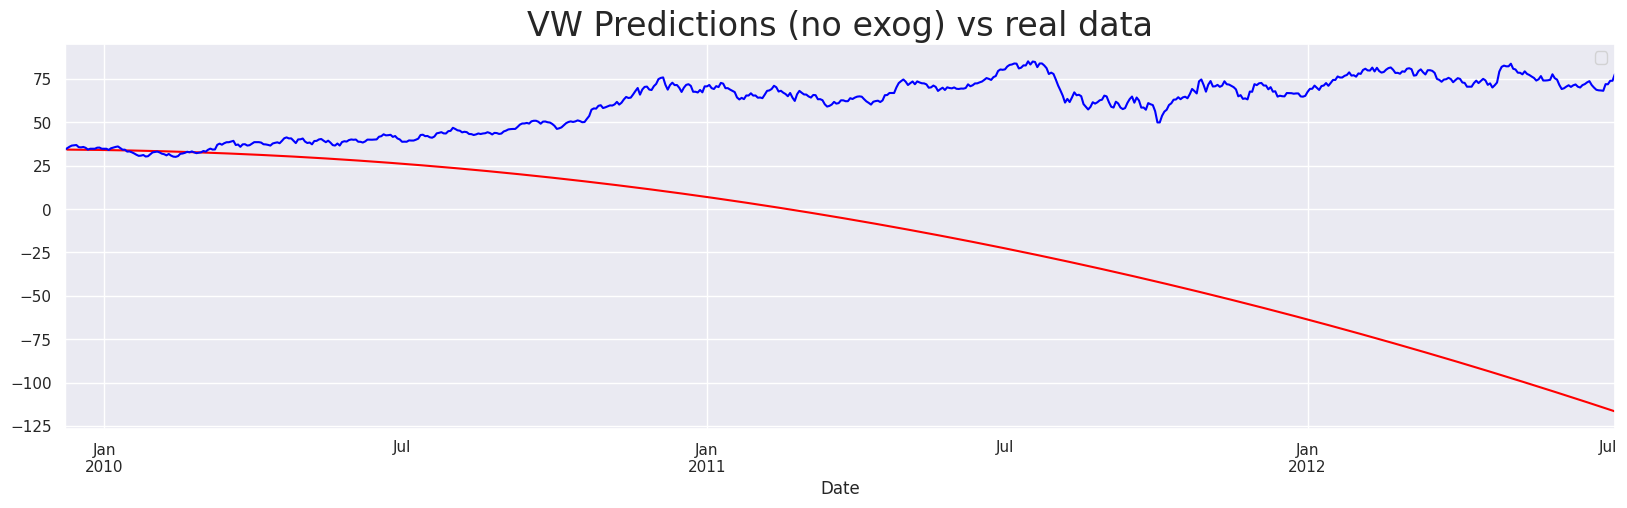

In [25]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],
                                m = 5,
                                max_p= 5,
                                max_q = 5,
                                max_P = 5,
                                max_Q = 5,
                                trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),index=df[ann_1:ann_2].index))
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red" )
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no exog) vs real data", size = 24)
plt.legend(['Predictions'], ['Actuals'])
plt.show()

at first glance the prediction seem very good over the three or four months This means that the model was able to capture the behavior of the stock prices quite well during this initial period. but then start to die off faster while the actual prices steadly bounced right up

this indicated that the announcement didn't make a great shifts in price trends for vw initially. The comment suggests that the announcement (which could be related to the events or information affecting Volkswagen's stock prices) didn't lead to significant shifts in the price trends for VW stock immediately after the announcement was made.

that can be attributed to the market lags where the new information as well as policy changes. take a while yo responed appropriately

t explains that while the initial prediction accuracy was high, the model's inability to capture the subsequent upward trend in actual prices might be due to the time it takes for the market to fully react to new information and adapt to changes in policies or conditions.


we notice that the forecasted prices are going down below zero which is impossible

let's zoom in

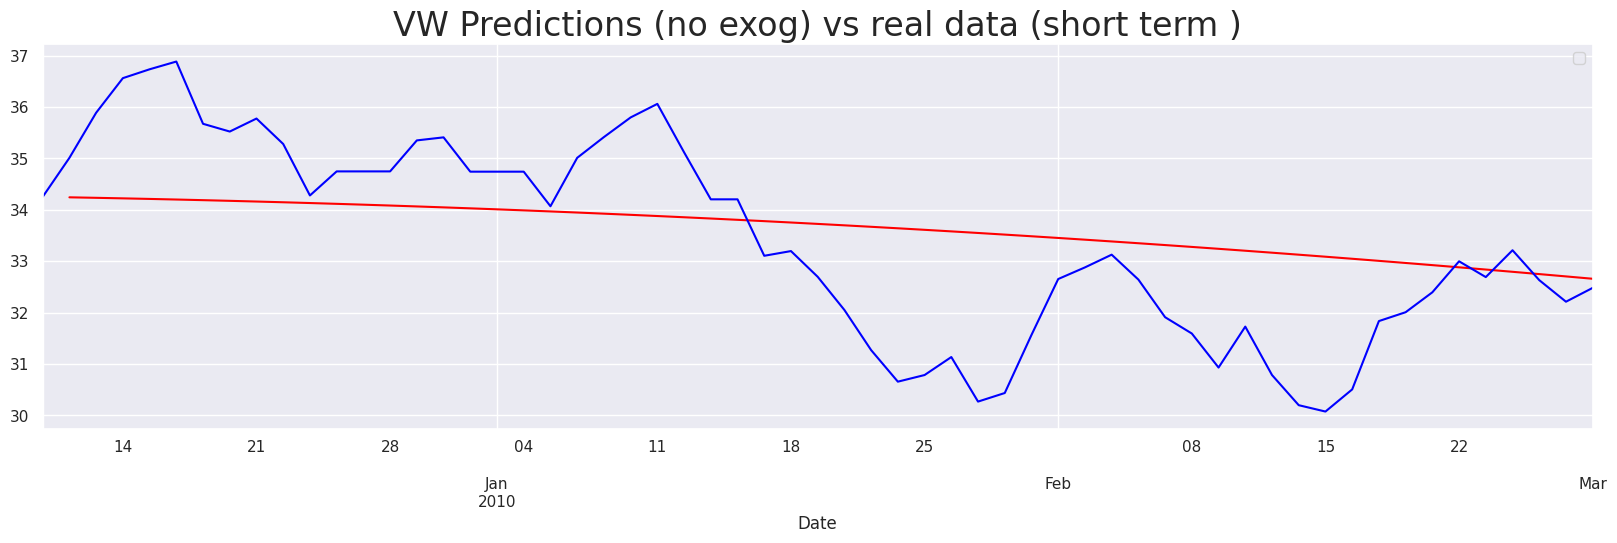

In [26]:
df_auto_pred_pr[ann_1:"2010-03-01"].plot(figsize = (20,5), color = "red" )
df.vol[ann_1:"2010-03-01"].plot(color = "blue")
plt.title("VW Predictions (no exog) vs real data (short term )", size = 24)
plt.legend(['Predictions'], ['Actuals'])
plt.show()

caputred the general trend over the entire period

this suggest the predicition would only be useful if we are trying to ballpark the quarterly performannce

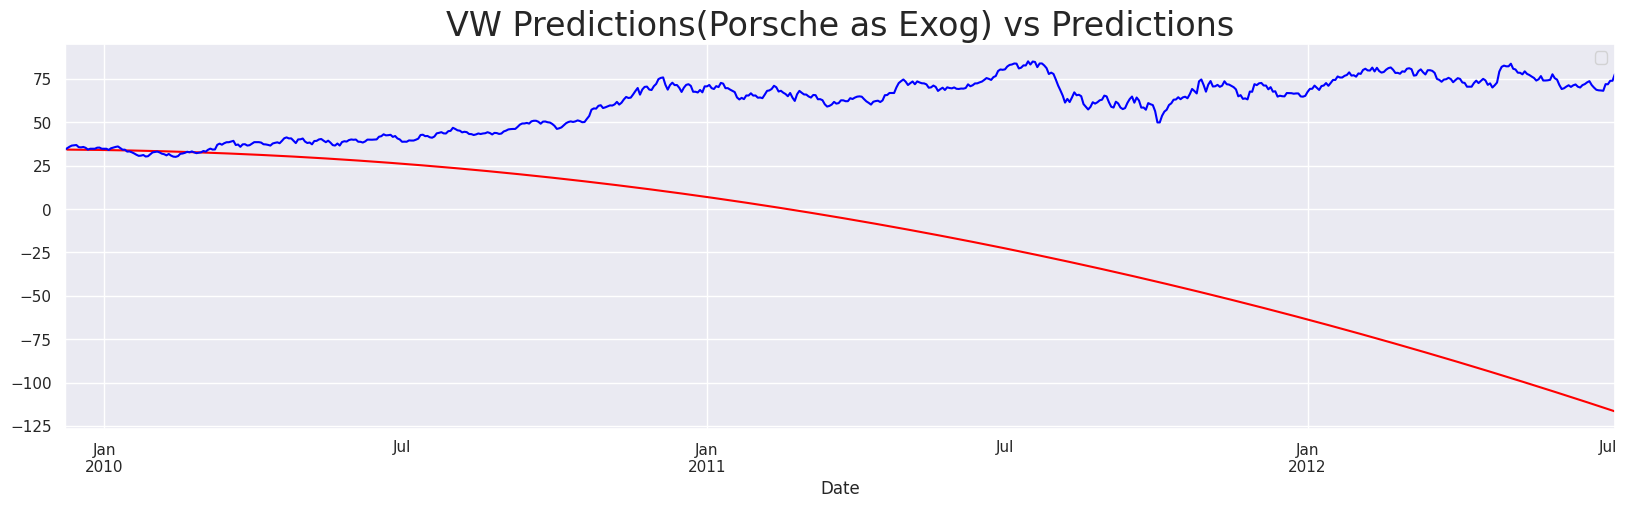

In [27]:
model_auto_pred_pr1 = auto_arima(df.vol[start_date:ann_1],
                                exogenous = df[['por']][start_date:ann_1],
                                m = 5,
                                max_p= 5,
                                max_q = 5,
                                max_P = 5,
                                max_Q = 5,
                                trend = 'ct')

df_auto_pred_pr1 = pd.DataFrame(model_auto_pred_pr1.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),index=df[ann_1:ann_2].index)
df_auto_pred_pr1[ann_1:ann_2].plot(figsize = (20,5), color = "red" )
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions(Porsche as Exog) vs Predictions", size = 24)
plt.legend(['Predictions'], ['Actuals'])
plt.show()

try to change the exogonous variable to bmw

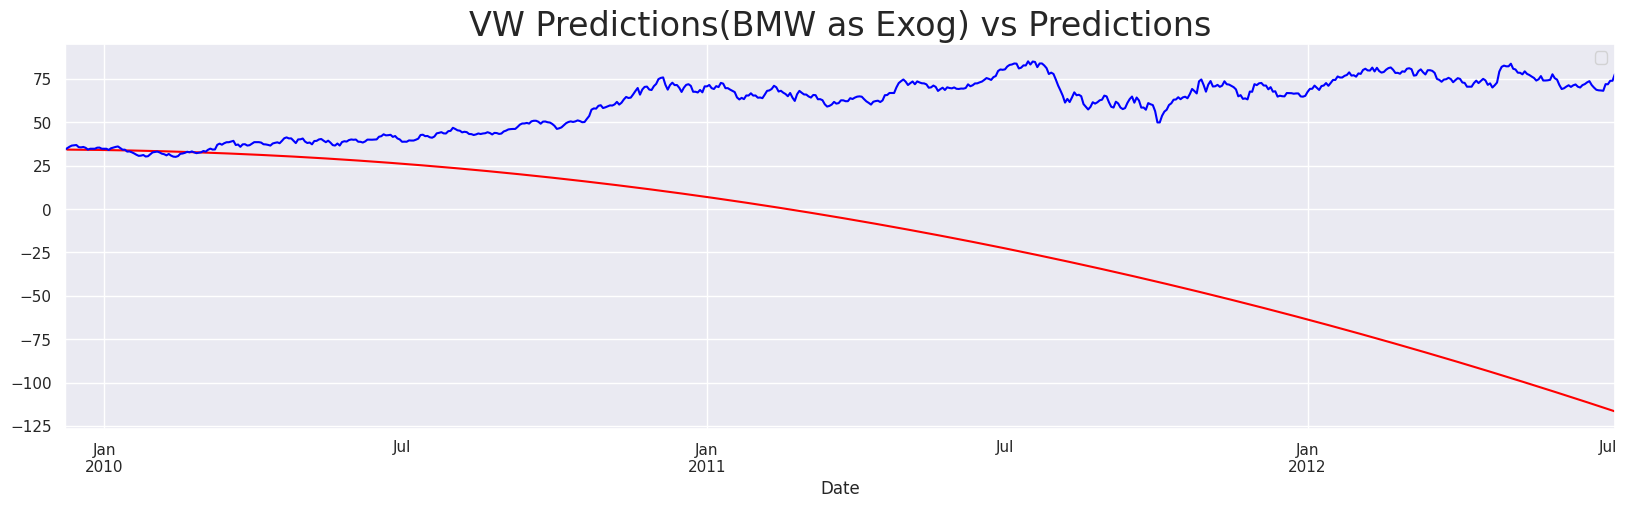

In [28]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],
                                exogenous = df[['bmw']][start_date:ann_1],
                                m = 5,
                                max_p= 5,
                                max_q = 5,
                                max_P = 5,
                                max_Q = 5,
                                trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['bmw']][ann_1:ann_2]),index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red" )
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions(BMW as Exog) vs Predictions", size = 24)
plt.legend(['Predictions'], ['Actuals'])
plt.show()

In [29]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1],
                                exogenous = df[['por','bmw']][start_date:ann_1],
                                m = 5,
                                max_p= 5,
                                max_q = 5,
                                max_P = 5,
                                max_Q = 5,
                                trend = 'ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por', 'bmw']][ann_1:ann_2]),index=df[ann_1:ann_2].index)

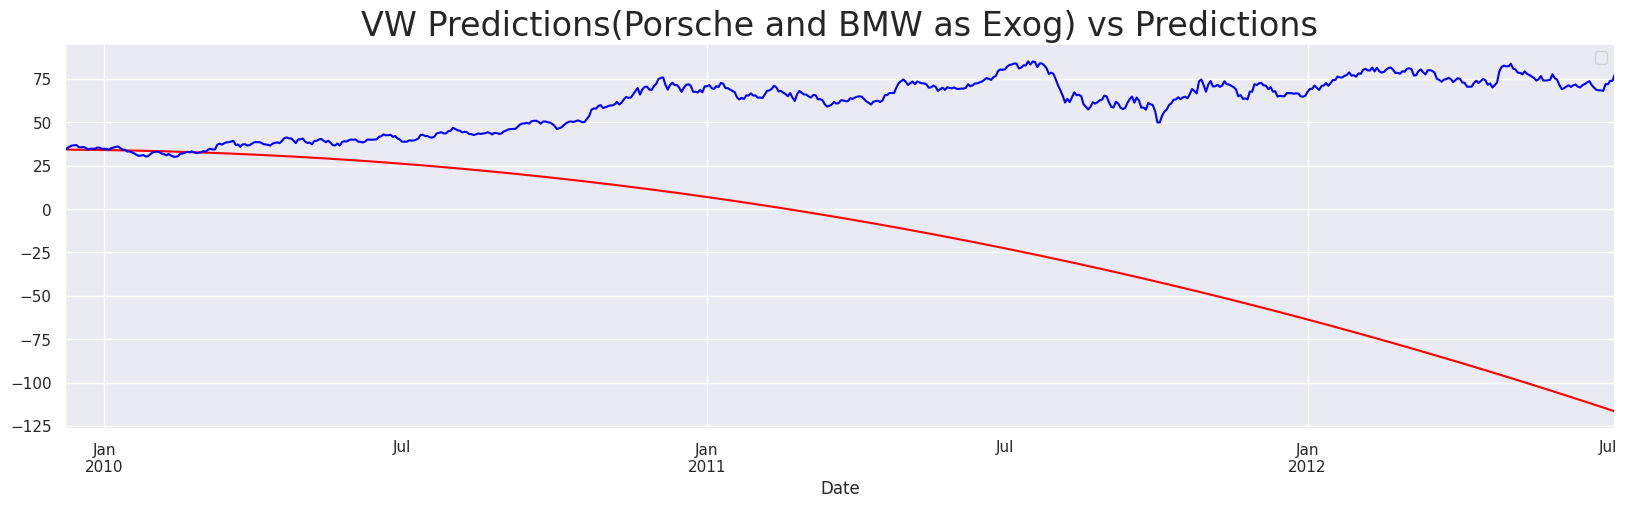

In [30]:
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red" )
df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions(Porsche and BMW as Exog) vs Predictions", size = 24)
plt.legend(['Predictions'], ['Actuals'])
plt.show()

no change

## Volatility

### Volatility of VW for Each Period

we  expect some major shifts surrounding such events

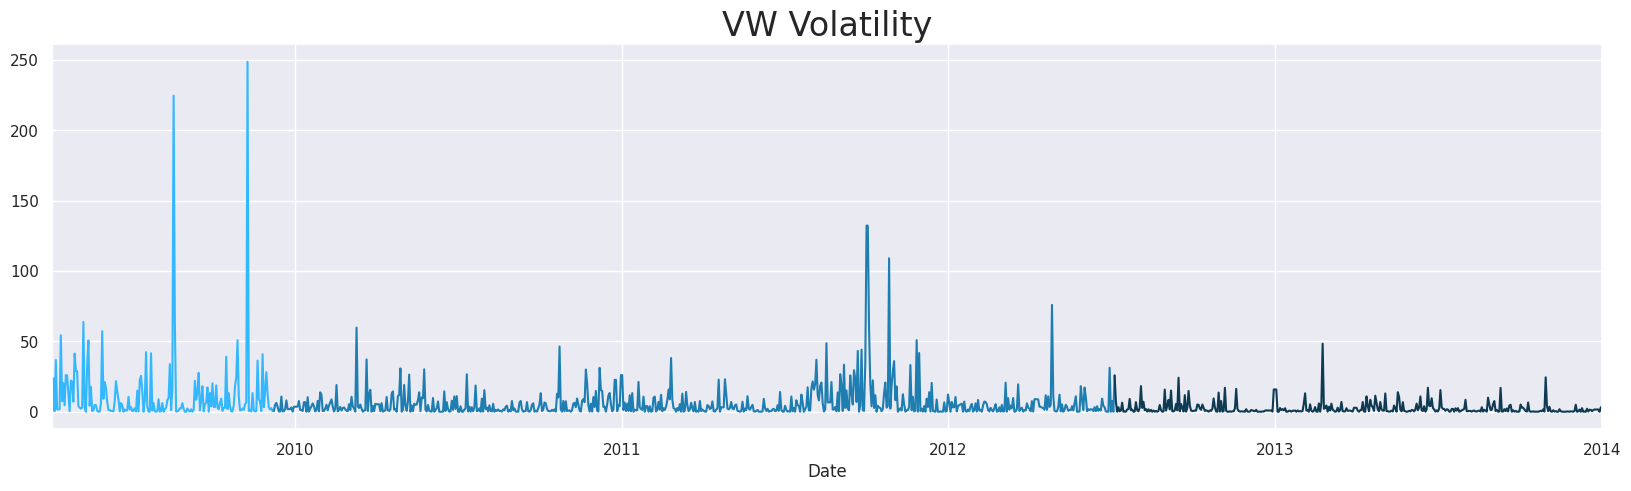

In [31]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = '#33B8FF' )
df['sq_vol'][ann_1:ann_2].plot(color = '#1E7EB2')
df['sq_vol'][ann_2:end_date].plot(color = '#0E3A52')
plt.title("VW Volatility", size = 24)
plt.show()

We see that VW has the highest volatility before any of the announcements

Notably, the stock becomes stable following each of the two announcements while, it showcases instability up to the time leading to each purchase

however, since porsche had initially tried to purchase vw a few years back , many people weren't certain of how it would all play out.

### Volatility Trends for Each Period

In [32]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2],  mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date],  mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7775167975834
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.0031363161705
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.990481490769
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.9904814384771
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.75331557947
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7313845400358
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7313845387916
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5622609213751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.557922236123
            Iterations: 7
            Funct

In [33]:
print(results_garch_pre.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.990
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Tue, Aug 15 2023   Df Residuals:                      177
Time:                        22:43:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.67

we see a p-value beta[1] =1 this shows that the trends and variance aren't as persistent as we would expect so no need to garch component a simple arch model would probably work better

 β (beta) represents the coefficient associated with the lagged squared residual terms in the volatility equation. In your output, the coefficient β[1] is estimated to be approximately 0.0000, and the associated p-value is 1.000.

When β = 1, it signifies that there is no conditional volatility feedback effect from the previous squared residual term to the current volatility. In other words, the past volatility doesn't influence the current volatility. This outcome is somewhat unusual and could indicate that the GARCH model doesn't find any significant contribution of the lagged squared residual terms in predicting volatility changes.




(β = 1: No volatility persistence. The past volatility does not affect the current volatility, and the volatility of the time series is not autocorrelated in this specific way. It suggests that shocks or changes in volatility don't tend to propagate from one time period to the next.

β > 1: Positive volatility persistence. This would indicate that past volatility shocks have a stronger impact on current volatility, possibly leading to more prolonged periods of high or low volatility.

β < 1: Negative volatility persistence. This would suggest that the impact of past volatility shocks on current volatility diminishes over time.)

In [34]:
print(results_garch_btn.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Tue, Aug 15 2023   Df Residuals:                      671
Time:                        22:43:42   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-0

Here, we observe that ß≈0; this means that the autocorrelation in the conditional variance is significant. Furthermore, the significant constant 'mu' indicates that theres is some constatnt trend in the 'Returns' values. Additionally, the value of omega shows that the exact same feature as Returns can be found in the volatility as well.


Hence, we never expect returns or their volatility to ever be perfectly stable(which is normal for markets lacking efficiency)

we never expect returns or their volatility to ever be perfectly stable

In [35]:
print(results_garch_post.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Tue, Aug 15 2023   Df Residuals:                      389
Time:                        22:43:42   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-0

Here, we observe non-significant values for alpha and omega which suggests that there is some autocorrelation in volatility which fits the Volatility Clustering Feature


_______________________________________________________________
#Overall, the purchase of Porche has provided Volkswagen with a larger share of the market. This in return, has resulted in much lower volatility after each announcement making VW stocks a more appealing prospect.

_______________________________________________________________________
mu: In the "Mean Model" section, mu represents the estimated mean or intercept of the return series. It signifies the average return level for the time series. In other words, this parameter represents the average return level around which the volatility fluctuates.

omega: In the "Volatility Model" section, omega is the estimated coefficient of the GARCH model's intercept term, which represents the baseline or constant component of conditional volatility. It is the contribution to volatility that is not explained by the lagged squared residuals or the ARCH and GARCH terms.  This parameter captures the baseline volatility level that the model cannot account for using other terms.

alpha[1]: This is the estimated coefficient of the first lag of the ARCH term in the GARCH model. The ARCH term captures the effect of past squared residuals on the current volatility. This parameter signifies the impact of recent past squared residuals on the current volatility.

beta[1]: This is the estimated coefficient of the first lag of the GARCH term in the GARCH model. The GARCH term captures the effect of past conditional volatility on the current volatility.  This parameter represents the persistence of volatility over time, where a value close to 1 indicates strong persistence.

Covariance Estimator: robust: The "Covariance estimator" indicates the method used to estimate the standard errors and other statistical properties of the coefficients. The "robust" estimator takes into account potential heteroskedasticity (non-constant variance) in the residuals.